In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('./1512623690_hour_20181214T0000_20201215T0000.csv', index_col='Fra', parse_dates=True , sep=";")
# Hent ut totaltall
moflata = data[(data['Felt'] == "Totalt i retning Moflata")]
myren   = data[(data['Felt'] == "Totalt i retning Myren")]

# Fjern kolonner som ikke skal brukes
#f_data = f_data[['Felt','Volum']]


/Users/oyvindlovoldbusk/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:283: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/Users/oyvindlovoldbusk/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/
https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/

In [2]:
m_moflata = moflata[['Volum']]
m_moflata.columns = ["Moflata"]
m_myren = moflata[['Volum']]
m_myren.columns = ["Myren"]
n_df = m_moflata.join(m_myren)
n_df.fillna(0, inplace=True)
n_df = n_df.replace("-", 0)
n_df['Moflata'] = n_df['Moflata'].astype(int)
n_df['Myren'] = n_df['Myren'].astype(int)
n_df['total'] = n_df['Moflata'] + n_df['Myren']


In [3]:
daily = n_df.resample('d').sum()
weekly = n_df.resample('w').sum()

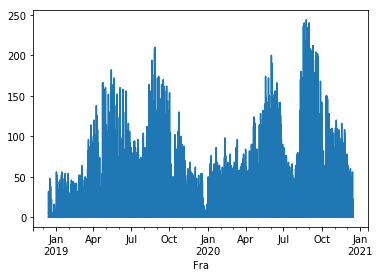

In [7]:
n_df['total'].plot()

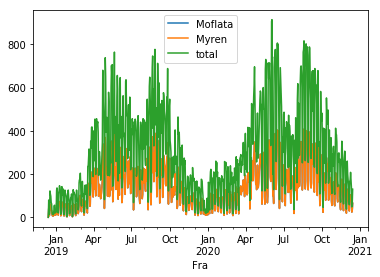

In [4]:
daily.plot()

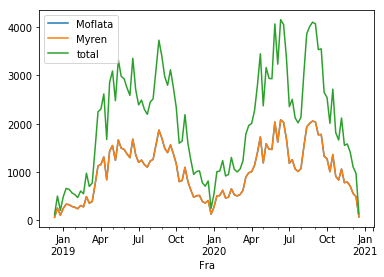

In [5]:
weekly.plot()

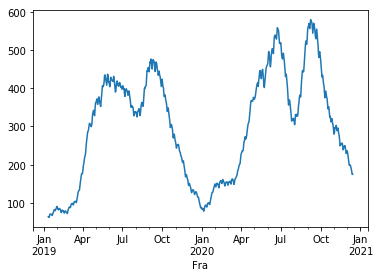

In [6]:
# 30 dagers Rolling average:
daily['total'].rolling(30).mean().plot()



In [ ]:
pivot_f_data = f_data.pivot_table(index='Fra',columns='Felt', values='Volum')
pivot_f_data.fillna(0, inplace=True)

In [8]:
# Define a function which returns the hours of daylight
# given the day of the year, from 0 to 365

def hours_of_daylight(date, axis=23.44, latitude=59.20962):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

# add this to our weekly data
weekly['daylight'] = map(hours_of_daylight, weekly.index)
daily['daylight'] = map(hours_of_daylight, daily.index)

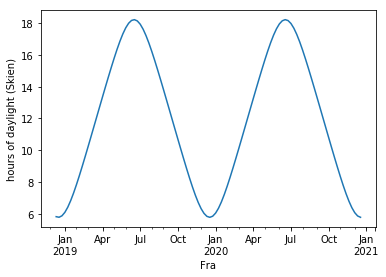

In [9]:
# Plot the daylight curve

weekly['daylight'].plot()
plt.ylabel('hours of daylight (Skien)');

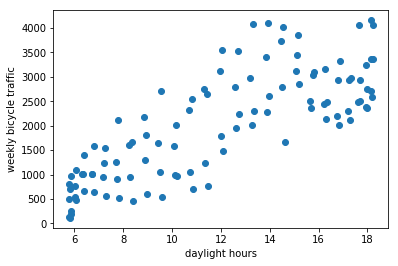

In [10]:
plt.scatter(weekly['daylight'], weekly['total'])
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

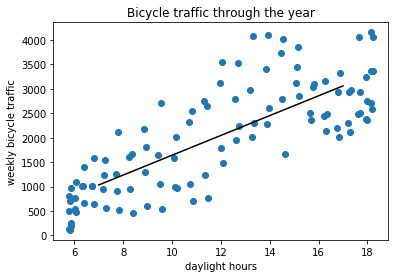

In [11]:
from sklearn.linear_model import LinearRegression

X = weekly[['daylight']].to_dense()
y = weekly['total']
clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly['total'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])
plt.scatter(weekly['daylight'], weekly['total'])
plt.plot(xfit, yfit, '-k')
plt.title("Bicycle traffic through the year")
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

In [12]:
print(clf.coef_[0])

202.78184303549537


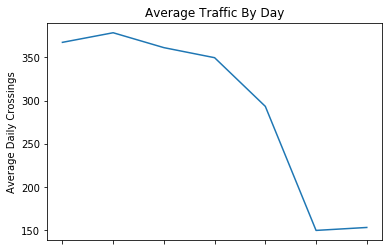

In [13]:
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
daily['dayofweek'] = daily['total'].index.dayofweek

grouped = daily.groupby('dayofweek')['total'].mean()
grouped.index = days

grouped.plot()
plt.title("Average Traffic By Day")
plt.xticks=grouped.index

plt.ylabel("Average Daily Crossings");

In [15]:
pivoted = n_df.pivot_table(['Myren', 'Moflata'],
                           index=n_df.index.date,
                           columns=n_df.index.hour,
                           fill_value=0)
pivoted.head()

Moflata                             ... Myren                       \
Fra             0  1  2  3  4  5   6  7  8  9  ...    14 15 16 17 18 19 20 21   
2018-12-13       0  0  0  0  0  0   0  0  0  0 ...     0  0  0  0  0  0  0  0   
2018-12-14       0  0  0  0  0  3  16  5  1  0 ...     3  2  0  0  1  0  2  1   
2018-12-15       0  0  0  0  0  0   0  0  1  0 ...     0  2  0  0  0  0  0  0   
2018-12-16       0  0  0  0  0  0   0  0  0  2 ...     0  0  0  0  0  2  1  0   
2018-12-17       0  0  0  0  0  6  24  6  4  1 ...     4  2  2  3  0  0  1  1   

                  
Fra        22 23  
2018-12-13  0  0  
2018-12-14  0  0  
2018-12-15  0  0  
2018-12-16  0  0  
2018-12-17  0  0  

[5 rows x 48 columns]

In [16]:
X = pivoted.values
X.shape

(733, 48)

In [17]:
from sklearn.decomposition import PCA
Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

(733, 4)

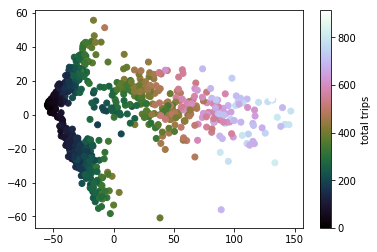

In [24]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='total trips');

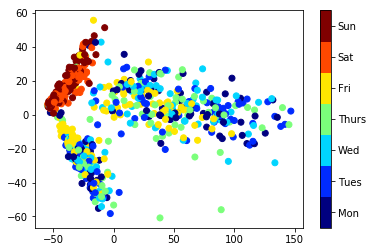

In [25]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);